<h1>Land Feature CNN</h1>

Code and network framework gathered from:
https://www.tensorflow.org/tutorials/images/cnn

Authors:
- Thao Pham
- Lawrence Hoerst


In [23]:
import theCropper
theCropper.main()

Cropping training raw images successful
Cropping testing raw images successful
Cropping validation colored images successful
Finished all cropping


In [24]:
import theScaler
theScaler.main()

Scaling dimensions set to (100, 100)
Scaled the training images
Scaled the testing images
Scaled the colored testing images
Scaled the colored training images
Finished all scaling


In [25]:
import converter
# This will load the colored images into np arrays and pickle them
converter.main()

starting the conversion process
10000
Training colored images converted successfully...
10000
Validation colored images converted successfully...
40000
Training input images converted successfully...
40000
Validation input images converted successfully...
Finished all conversions


In [26]:
# Import tensorflow for the model
import tensorflow as tf
from tensorflow.keras import layers, models
# Import matplotlib to show retults
import matplotlib.pyplot as plt
# Import numpy for data processing
import numpy as np
# Import from PIL
from PIL import Image
from PIL import ImageColor
# Import pickle to read in training data
import pickle
# Import os to work with filepaths
import os
# Import time for sleep
import time

In [27]:
# Class names to plot the images:
class_names = ['Water', 'Buildings', 'Roads', 'Foliage', 'Mineral deposits', 'Mountainous terrain', 'Rocky terrain', 'Sandy terrain', 'Plains', 'Snow', 'Grass']
class_colors = ['#0f5e9c', ('#f2f2f2', '#606060'), '#c4c4c4', '#3a5f0b', '#490e0e', '#5a7a4c', '#698287', '#f7ae64', '#c89e23', '#fffafa', '#7cfc00']
class_codes = {class_names[i]: i for i in range(len(class_names))}

# hex_to_rgb
cvt = lambda hex: ImageColor.getcolor(hex, "RGB")
colors_to_code = {cvt('#0f5e9c'): 0,
                  cvt('#f2f2f2'): 1, cvt('#606060'): 1,
                  cvt('#c4c4c4'): 2,
                  cvt('#3a5f0b'): 3,
                  cvt('#490e0e'): 4,
                  cvt('#5a7a4c'): 5,
                  cvt('#698287'): 6,
                  cvt('#f7ae64'): 7,
                  cvt('#c89e23'): 8,
                  cvt('#fffafa'): 9,
                  cvt('#7cfc00'): 10,
                  'default':      11}

In [60]:
# Instantiate the model
model = models.Sequential()
# Add layers
# We need to decide on how many layers we want
# These parameters are not yet setup for our network
model.add(layers.InputLayer(shape=(*theScaler.scalingDimensions, 4)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(theScaler.scalingDimensions[0] * theScaler.scalingDimensions[1], activation='relu'))
model.add(layers.Dense(theScaler.scalingDimensions[0] * theScaler.scalingDimensions[1], activation='sigmoid'))
model.add(layers.Reshape((*theScaler.scalingDimensions, 1))) # Make output in the same shape as a classification image
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
print("Shape of input: ",(*theScaler.scalingDimensions, 4))
print(model.summary())

Shape of input:  (100, 100, 4)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 98, 98, 32)          │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10000)               │     282,250,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10000)               │     100,010,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 100, 100, 1)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 382,316,608 (1.42 GB)

 Trainable params: 382,316,608 (1.42 GB)

 Non-trainable params: 0 (0.00 B)

None


In [62]:
# unpickle our test data here
input_sizing = lambda array: [np.reshape(value, (-1, *theScaler.scalingDimensions, 4)) for value in array]
output_sizing = lambda array: [np.reshape(value, (-1, *theScaler.scalingDimensions, 1)) for value in array]
resize = False
with open('training_inputs.pickle', 'rb') as inputsFile:
    training_inputs = pickle.load(inputsFile)
    if resize: training_inputs = input_sizing(training_inputs)
with open('training_outputs.pickle', 'rb') as outputsFile:
    training_outputs = pickle.load(outputsFile)
    if resize: training_outputs = output_sizing(training_outputs)

# unpickle the validation / testing outputs
with open('validation_inputs.pickle', 'rb') as inputsFile:
    validation_inputs = pickle.load(inputsFile)
    if resize: validation_inputs = input_sizing(validation_inputs)
with open('validation_outputs.pickle', 'rb') as outputsFile:
    validation_outputs = pickle.load(outputsFile)
    if resize: validation_outputs = output_sizing(validation_outputs)

print_data = lambda func: print(f"training inputs: {func(training_inputs)}, training outputs: {func(training_outputs)}, validation inputs: {func(validation_inputs)}, and validation outputs: {func(validation_outputs)}")
print_data(len)
print_data(lambda e: e[0].shape)



training inputs: 60, training outputs: 60, validation inputs: 20, and validation outputs: 20
training inputs: (100, 100, 4), training outputs: (100, 100, 1), validation inputs: (100, 100, 4), and validation outputs: (100, 100, 1)


In [63]:
# Train the model
history = model.fit(training_inputs, training_outputs, epochs=100, validation_data=(validation_inputs, validation_outputs))

Epoch 1/100


TypeError: Expected float32, but got <keras.src.losses.losses.CategoricalCrossentropy object at 0x00000221F153AC90> of type 'CategoricalCrossentropy'.

1/1 - 0s - 106ms/step - accuracy: 0.0000e+00 - loss: 6.6510


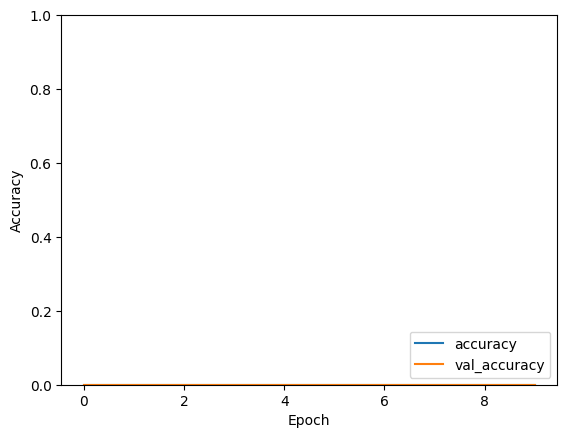

In [46]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(validation_inputs,  validation_outputs, verbose=2)

In [59]:
def predict(np_array):
    prediction = model.predict(np.reshape(np_array, (-1, *theScaler.scalingDimensions, 4)))
    prediction =  np.reshape(prediction, (*theScaler.scalingDimensions, 1))
    prediction_decoded = converter.decode_image(prediction)
    predicted_image = Image.fromarray(prediction_decoded)
    predicted_image.show()
predict(training_inputs[0])
time.sleep(5)
predict(training_inputs[1])
time.sleep(5)
predict(training_inputs[2])
time.sleep(5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
